# Skoda Auto - rides

This notebook uses Skoda rides data. The data covers movement of vehicles for work-related trips for period March to September 2019.

TODO:
- nahrat vsechny trips/postupne zprocesovat - PROBLEM
- varianta 1: points to trajectry v  postgis + detectstops (A.Graser)
- varianta 2: points, adapted detectstops to add column trip, trajectory pomoci group by (carid,trip)
- vypsat statistiky (sql po inicializaci/pandas) - jake vsechny?
- poresit carid to be categorized not continuous int - DONE
- dopocitat speed (movingpandas function) - DONE
- origins/destinations do postgis db 
- statistiky pro dny/podle hodin - histogram?
- clustering origins/destinations v postgisu

 

In [5]:
%matplotlib inline

In [55]:
import urllib
import os
import pandas as pd
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import psycopg2
from debug import *
import datetime
import sys
sys.path.append("..")
import movingpandas as mp

import warnings
warnings.simplefilter("ignore")

## Area of interest: Europe

Using zoom level 8, this will download 196 tiles
CPU times: user 33.1 ms, sys: 14.4 ms, total: 47.5 ms
Wall time: 51.1 ms


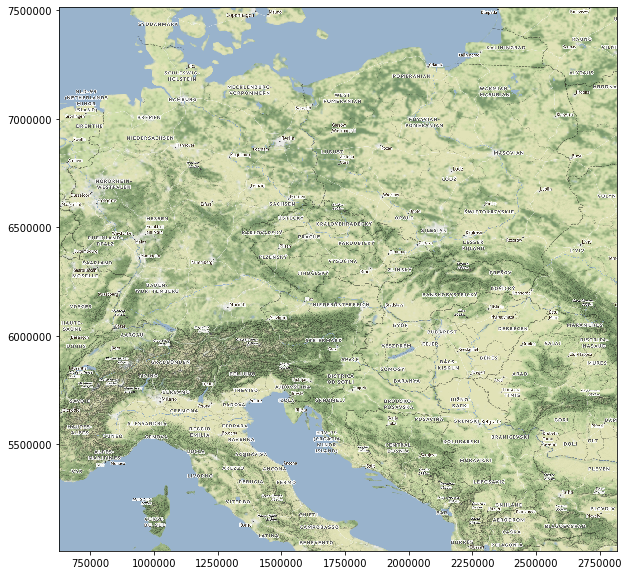

In [7]:
ZOOM_LEVEL = 8
w, s, e, n = 6, 43, 24, 54.5

# check number of tiles that will be downloaded
ctx.howmany(w, s, e, n, ZOOM_LEVEL, ll=True)

# download tiles
%time img, ext = ctx.bounds2img(w, s, e, n, ZOOM_LEVEL-1, ll=True)

# plot map 
plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(img, extent=ext, aspect='auto')

## Loading data from PostGIS db


In [8]:
con = psycopg2.connect(database="skoda-postgres", user="root", password="sumpr0ject",
    host="localhost", port=35432)
sql = "SELECT * FROM rides LIMIT 100000;"
# sql = "SELECT * FROM rides WHERE carid IN ('524305','536208') AND datetime BETWEEN '2019-05-10' AND '2019-05-11';"

df = GeoDataFrame.from_postgis(sql, con, geom_col='geometry' )

Let's see what the data looks like:

In [9]:
wgs84 = df.crs
df.head()
# df.dtypes

,carid,datetime,geometry
0,524305,2019-03-01 11:44:06,POINT (14.92328 50.42229)
1,524305,2019-03-01 11:44:16,POINT (14.92506 50.42212)
2,524305,2019-03-01 11:44:27,POINT (14.92652 50.42167)
3,524305,2019-03-01 11:44:33,POINT (14.92675 50.42142)
4,524305,2019-03-01 11:44:43,POINT (14.92742 50.42102)


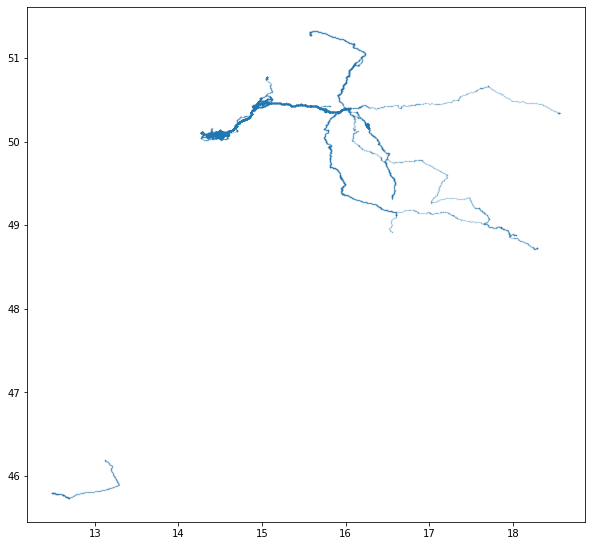

In [10]:
df.plot(markersize=0.1, alpha=0.2)

To convert the DataFrame to Trajectories we need to create a temporal index:

In [11]:
df['t'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('t')
#df['carid']=df['carid'].astype(int)
type(df['carid'])


pandas.core.series.Series

If we look at the data distributions, we can see that there are a lot of records with speed over ground (SOG) values of zero in this dataframe:

2019-03-01 05:47:27
2019-09-13 15:07:21


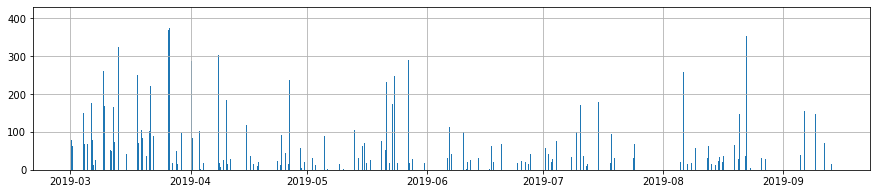

In [12]:
start_day = min(df['datetime'])
end_day = max(df['datetime'])
print(start_day)
print(end_day)
df['datetime'].hist(bins=4000, figsize=(15,3))

Let's get rid of these rows with zero SOG:

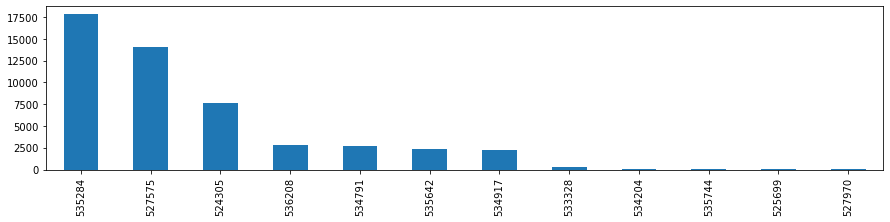

In [13]:
df['carid'].value_counts().plot(kind='bar', figsize=(15,3))


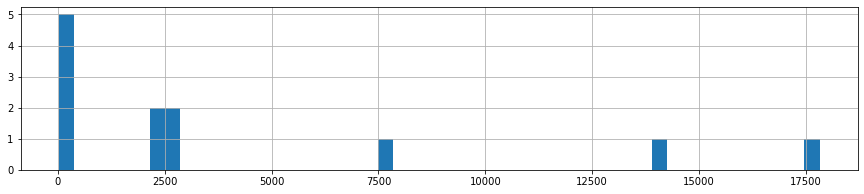

In [14]:


df['carid'].value_counts().hist(bins=50,figsize=(15,3))

Finally, let's create trajectories:

In [15]:
MIN_LENGTH = 100 # meters

t_start = datetime.now()


trajectories = []
generalized_trajs = []
            
for key, values in df.groupby(['carid']):
    if len(values) < 2:
        continue
    trajectory = mp.Trajectory(key, values)
    if trajectory.get_length() < MIN_LENGTH:
        continue
#     print(trajectory)
    trajectories.append(trajectory)
    generalized_trajs.append(trajectory.generalize(mode='douglas-peucker', tolerance=0.001)) #(mode='min-time-delta', tolerance=timedelta(minutes=5))

print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished creating 12 trajectories in 0:00:13.465169


## Plotting trajectories

Let's give the most common ship types distinct colors. The remaining ones will be just grey:

In [21]:
def plot_car_trajectories(trajs):
    shiptype_to_color = {
        'Passenger': 'blue', 
        'HSC': 'green', 
        'Tanker': 'red',
        'Cargo': 'orange'}
    default_color = 'blue'

    ax = None
    for traj in trajs:
#         ship_type = traj.df['ShipType'].iloc[0]
        ship_type = None

        try:
            ship_color = shiptype_to_color[ship_type]
        except KeyError:
            ship_color = default_color

        if ax is None:
            ax = traj.plot(linewidth=1, capstyle='round', column='Name', legend=True, figsize=(12,9), color=ship_color)
        else:
            traj.plot(ax=ax, linewidth=1, capstyle='round', column='Name', legend=True, figsize=(12,9), color=ship_color) 

CPU times: user 7.03 s, sys: 178 ms, total: 7.21 s
Wall time: 6.26 s


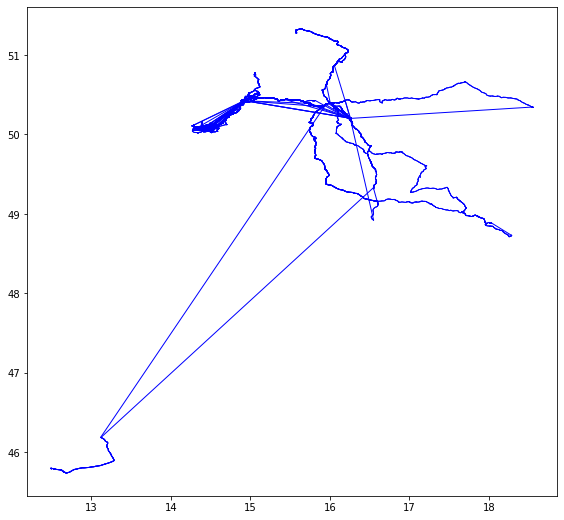

In [22]:
%%time
plot_car_trajectories(trajectories)

CPU times: user 1.98 s, sys: 107 ms, total: 2.08 s
Wall time: 1.42 s


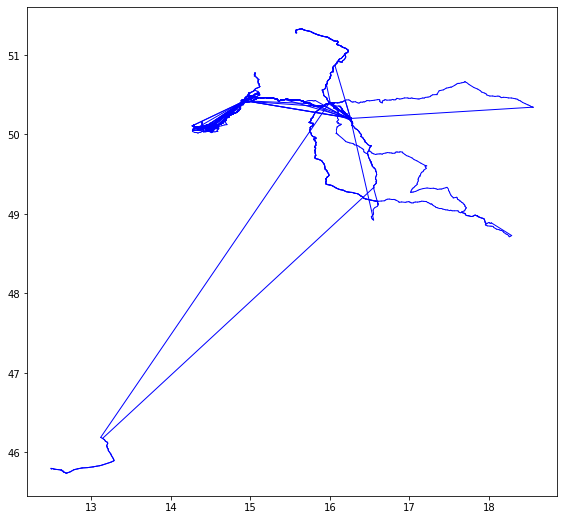

In [42]:
%%time
plot_car_trajectories(generalized_trajs)

## Visualizing trajectory properties

We can also plot individual trajectories to better visualize their properties, such as the changes in NavStatus:

In [16]:
my_traj = trajectories[0]
my_traj.df.head()

,carid,datetime,geometry
t,,,
2019-03-01 11:44:06,524305,2019-03-01 11:44:06,POINT (14.92328 50.42229)
2019-03-01 11:44:16,524305,2019-03-01 11:44:16,POINT (14.92506 50.42212)
2019-03-01 11:44:27,524305,2019-03-01 11:44:27,POINT (14.92652 50.42167)
2019-03-01 11:44:33,524305,2019-03-01 11:44:33,POINT (14.92675 50.42142)
2019-03-01 11:44:43,524305,2019-03-01 11:44:43,POINT (14.92742 50.42102)


In [17]:
my_traj.df.tail()

,carid,datetime,geometry
t,,,
2019-09-13 10:31:11,524305,2019-09-13 10:31:11,POINT (14.91926 50.42253)
2019-09-13 10:31:16,524305,2019-09-13 10:31:16,POINT (14.91941 50.42256)
2019-09-13 10:31:36,524305,2019-09-13 10:31:36,POINT (14.91948 50.42281)
2019-09-13 10:31:44,524305,2019-09-13 10:31:44,POINT (14.91976 50.42280)
2019-09-13 10:32:45,524305,2019-09-13 10:32:45,POINT (14.92003 50.42279)


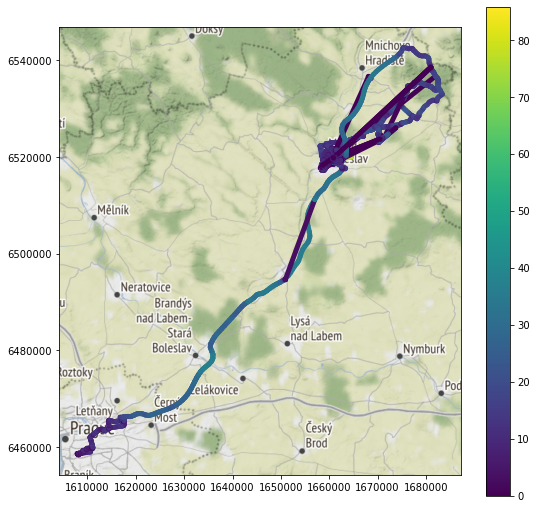

In [18]:
ZOOM_LEVEL = 10  # don't increase to ZOOM_LEVEL >= 15 because this causes a tile not found 404 error
my_traj.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', legend=True, 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Note: When plotting with basemap, you may run into missing map tiles. For Stamen, you can check map tile availability for a region and zoom level at http://maps.stamen.com/#terrain/15/57.6714/11.8120

Available tile sources are listed in https://github.com/darribas/contextily/blob/master/contextily/tile_providers.py, e.g.

```
ST_TONER = 'http://tile.stamen.com/toner/{z}/{x}/{y}.png'
ST_TONER_HYBRID = 'http://tile.stamen.com/toner-hybrid/{z}/{x}/{y}.png'
ST_TONER_LABELS = 'http://tile.stamen.com/toner-labels/{z}/{x}/{y}.png'
ST_TONER_LINES = 'http://tile.stamen.com/toner-lines/{z}/{x}/{y}.png'
ST_TONER_BACKGROUND = 'http://tile.stamen.com/toner-background/{z}/{x}/{y}.png'
ST_TONER_LITE = 'http://tile.stamen.com/toner-lite/{z}/{x}/{y}.png'

ST_TERRAIN = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
ST_TERRAIN_LABELS = 'http://tile.stamen.com/terrain-labels/{z}/{x}/{y}.png'
ST_TERRAIN_LINES = 'http://tile.stamen.com/terrain-lines/{z}/{x}/{y}.png'
ST_TERRAIN_BACKGROUND = 'http://tile.stamen.com/terrain-background/{z}/{x}/{y}.png'

ST_WATERCOLOR = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
```

More on plotting GeoPandas GeoDataframes: http://geopandas.org/gallery/plotting_basemap_background.html

## Finding ships passing under Älvsborgsbron bridge - USELESS
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [ ]:
area_of_interest = Polygon([(
              14.924583435058592,
              50.43126756156562),
            (
              14.918060302734375,
              50.420495471498114
            ),
            (
              14.938144683837889,
              50.413330948495485
            ),
            (
              14.941835403442383,
              50.42558107823979
            ),
            (
              14.924583435058592,
              50.43126756156562
            )])

In [ ]:
intersections = []
for traj in trajectories:
    if traj.to_linestring().intersects(area_of_interest):
        intersections.append(traj)
print("Found {} intersections".format(len(intersections)))

In [ ]:
bridge_traj = intersections[3]
bridge_traj.plot(with_basemap=True, linewidth=5, capstyle='round', column='carid', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

In [ ]:
bridge_traj.df.head()

## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [19]:
trips = []
for traj in trajectories:
    for x in traj.split_by_observation_gap(timedelta(minutes=5)):
        if x.get_length() > MIN_LENGTH:
            trips.append(x)
print("Extracted {} individual trips from {} continuous car tracks".format(len(trips), len(trajectories)))

Extracted 945 individual trips from 12 continuous vessel tracks


*Note: Splitting continous observations by observation gap is a straightforward way to extract individual trips. More sophisticated approaches require stop detection methods that do not require extended periods of time where the speed is at zero. MovingPandas so far does not implement such stop detection functions.*

Let's plot the resulting trips!

CPU times: user 2min 53s, sys: 9.43 s, total: 3min 3s
Wall time: 2min 5s


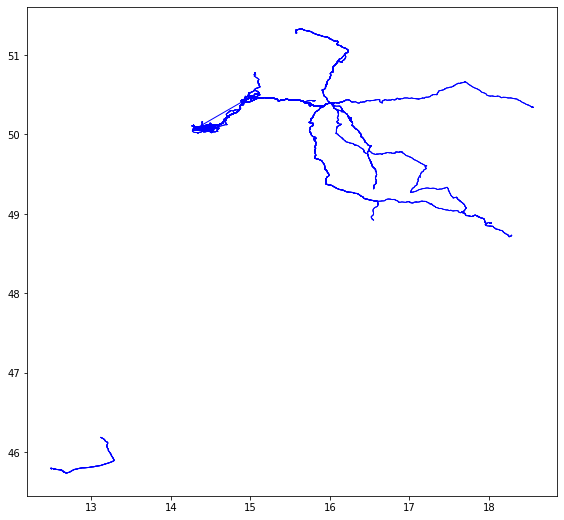

In [23]:
%%time
plot_car_trajectories(trips)

Compared to plotting the original continuous observations, this visualization is much cleaner because there are no artifacts at the border of the area of interest. 

Next, let's get the trip origins:

In [45]:
origins = []
for trip in trips:
    origins.append({'geometry': trip.get_start_location(), 'id': trip.id, 
                    'carid': trip.df.head(1)['carid'][0],'datetime': trip.get_start_time()})
origins = GeoDataFrame(pd.DataFrame(origins), crs=wgs84)

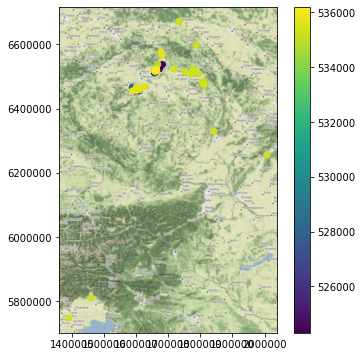

In [46]:
ax = origins.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(6,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

In our data sample, trip origins can be:
- When a ship departs its anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

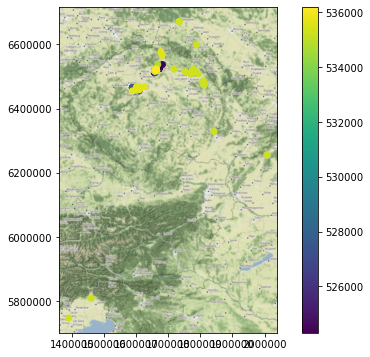

In [47]:
ax = origins.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(9,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

Let's get trip destinations:

In [48]:
destinations = []
for trip in trips:
    destinations.append({'geometry': trip.get_end_location(), 'id': trip.id, 
                    'carid': trip.df.head(1)['carid'][0],'datetime': trip.get_end_time()})
destinations = GeoDataFrame(pd.DataFrame(destinations), crs=wgs84)

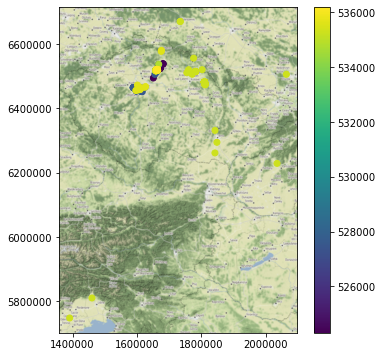

In [49]:
ax = destinations.to_crs(epsg=3857).plot(column='carid', legend=True, figsize=(6,6))
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL)

## Movement around Mlada Boleslav

In [24]:
# area in 10km proximity of Mlada Boleslav
area_MB = Polygon([(
              14.826675,          
              50.483558
            ),
            (
              14.824272,
              50.368292
            ),
            (
              15.018936,
              50.338281
            ),
            (
              15.028549,
              50.477004
            )])

In [26]:
foundTrips = []
for traj in trips:
    if traj.get_start_location().intersects(area_MB):
        foundTrips.append(traj)
print("Found {} trips starting from MB".format(len(foundTrips)))

Found 782 trips starting from MB


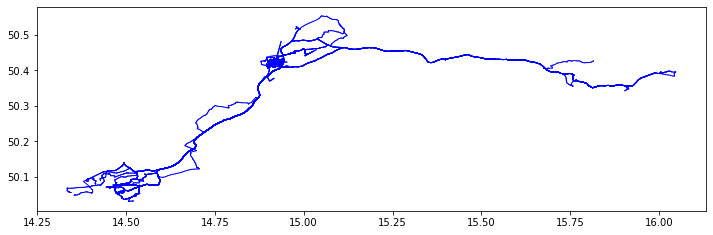

In [27]:
plot_car_trajectories(foundTrips)

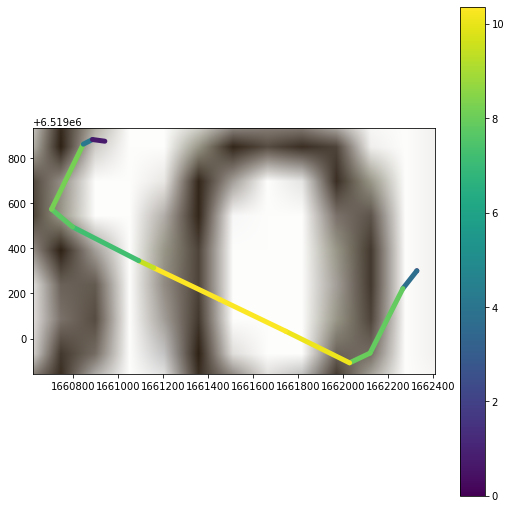

In [30]:
foundTrips[1].plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', legend=True, 
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

## Finding vehicles that depart from Karlovo namesti CTU

In [ ]:
# karlovo namesti CVUT areal
area_of_interest = Polygon([(
              14.416846632957458,
              50.076604219275936
),
            (
              14.416674971580505,
              50.076490610564875
            ),
            (
              14.416835904121399,
              50.07602584485287
            ),
            (
              14.418354034423826,
              50.07610502747774
            ),
            (
              14.41826283931732,
              50.07671094236533
            ),
            (
              14.416846632957458,
              50.076604219275936
            )])

We can identify cars that start their trip within a given area of interest by intersecting trip starting locations with our area of interest:

In [ ]:
departures = []
for traj in trips:
    if traj.get_start_location().intersects(area_of_interest):
        departures.append(traj)
print("Found {} departures".format(len(departures)))

In [ ]:
departures[1].plot(with_basemap=True, linewidth=5, capstyle='round', column='carid', legend=True,
                          figsize=(9,9), url=ctx.sources.ST_TERRAIN, zoom=ZOOM_LEVEL) 

Let's see what kind of ships depart from here:

In [ ]:
for traj in departures:
    print("{} Car '{}' departed at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_start_time()))

Of course, the same works for arrivals:

In [ ]:
arrivals = []
for traj in trips:
    if traj.get_end_location().intersects(area_of_interest):
        arrivals.append(traj)
print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("{} car '{}' arrived at {}".format(traj.df['carid'].iloc[0], traj.df['carid'].iloc[0], traj.get_end_time()))

## Additional statistics

### Speed

In [ ]:
#Avg speed in km/h
avgSpeed = []
for trajectory in trips:
    trajectory.add_speed(overwrite=True)
    avgSpeed.append((sum(trajectory.df.speed)/trajectory.df.speed.size)*3.6)

In [ ]:
trajectories[3].get_length()/1000

In [ ]:
type(trajectories[0])

In [31]:
print("Trajectories of " +  str(len(df.carid.unique())) + " unique users")



Trajectories of 12 unique users



In [54]:
distances = [] #in km
durations = []
for trip in trips:
    distances.append(trip.get_length()/1000)
    durations.append(int(trip.get_duration()))
totalDistance = sum(distances)

print("Total traveled distance " + str(totalDistance))


TypeError: int() argument must be a string, a bytes-like object or a number, not 'datetime.timedelta'

In [58]:
totalDuration = sum(durations, datetime.timedelta(0))
totalDuration

datetime.timedelta(0)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'datetime.timedelta'